# **Import Statements**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import seaborn as sns
from keras.models import Model
import cv2
from tensorflow.keras import backend as K

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
data_dir = pathlib.Path('/content/drive/MyDrive/Grading_dataset')

# **Data Augmentation**

In [27]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 480 images belonging to 3 classes.
Found 120 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [28]:
def show_image_samples(generator):
    # Get the class indices from the generator
    class_indices = generator.class_indices

    # Get the class names from the class indices
    class_names = list(class_indices.keys())

    # Get a sample batch from the generator
    images, labels = next(generator)

    # Plot the images and their labels
    plt.figure(figsize=(10, 10))
    for i in range(min(images.shape[0], 25)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()

In [29]:
from collections import Counter

# Check the class distribution
class_counts = train_generator.class_indices
print(f"Class indices: {class_counts}")

# Check class counts
train_labels = train_generator.classes
print(Counter(train_labels))


Class indices: {'Over_Ripen': 0, 'Perfect_Ripen': 1, 'Under_Ripen': 2}
Counter({0: 160, 1: 160, 2: 160})


# **Check**

# **VGG-16**

In [30]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
for layer in vgg_model.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable = False

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
        train_generator,
        epochs=100,
        validation_data=validation_generator,
        verbose=1)

Epoch 1/100
15/15 [==============================] - 14s 775ms/step - loss: 1.6020 - accuracy: 0.4875 - val_loss: 7.4868 - val_accuracy: 0.3333
Epoch 2/100
15/15 [==============================] - 11s 760ms/step - loss: 1.1633 - accuracy: 0.5896 - val_loss: 10.6471 - val_accuracy: 0.3333
Epoch 3/100
15/15 [==============================] - 11s 751ms/step - loss: 1.0540 - accuracy: 0.5958 - val_loss: 7.1289 - val_accuracy: 0.3333
Epoch 4/100
15/15 [==============================] - 13s 888ms/step - loss: 0.8744 - accuracy: 0.6667 - val_loss: 3.8620 - val_accuracy: 0.4333
Epoch 5/100
15/15 [==============================] - 13s 877ms/step - loss: 0.9277 - accuracy: 0.6625 - val_loss: 2.8792 - val_accuracy: 0.3583
Epoch 6/100
15/15 [==============================] - 11s 715ms/step - loss: 0.8494 - accuracy: 0.6771 - val_loss: 0.8828 - val_accuracy: 0.5833
Epoch 7/100
15/15 [==============================] - 11s 769ms/step - loss: 0.7857 - accuracy: 0.7042 - val_loss: 1.1219 - val_accuracy

# **Summary of layers**

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

# **Saving Model**

In [ ]:
model.save('/content/drive/MyDrive/Grading_dataset/vgg_model300.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **EfficientNet**

In [18]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers, layers, Model
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.optimizers import Adamax
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


sdir = '/content/drive/MyDrive/Grading_dataset'
classlist = os.listdir(sdir)
filepaths = []
labels = []
for c in classlist:
    classpath = os.path.join(sdir, c)
    for f in os.listdir(classpath):
        filepaths.append(os.path.join(classpath, f))
        labels.append(c)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

In [19]:
trsplit = 0.8
vsplit = 0.1
dsplit = vsplit / (1 - trsplit)
train_df, dummy_df = train_test_split(df, train_size=trsplit, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123)

print(f'train_df length: {len(train_df)}, test_df length: {len(test_df)}, valid_df length: {len(valid_df)}')
print(f'Class distribution in training set: {train_df["labels"].value_counts().values}')

height, width, channels = 224, 224, 3
batch_size = 30
img_size = (height, width)
length = len(test_df)
test_batch_size = max([int(length / n) for n in range(1, length + 1) if length % n == 0 and length / n <= 80])
test_steps = int(length / test_batch_size)
print(f'test batch size: {test_batch_size}, test steps: {test_steps}')

train_df length: 480, test_df length: 60, valid_df length: 60
Class distribution in training set: [163 159 158]
test batch size: 60, test steps: 1


In [20]:
def scalar(img): return img

trgen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen = ImageDataGenerator(preprocessing_function=scalar)
train_gen = trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = tvgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen = tvgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
classes = list(train_gen.class_indices.keys())
class_count = len(classes)
train_steps = np.ceil(len(train_gen.labels) / batch_size)

base_model = EfficientNetB2(include_top=False, weights="imagenet", input_shape=(height, width, channels), pooling='max')
x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(base_model.output)
x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
                 bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = layers.Dropout(rate=0.45, seed=123)(x)
output = layers.Dense(class_count, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Found 480 validated image filenames belonging to 3 classes.
Found 60 validated image filenames belonging to 3 classes.
Found 60 validated image filenames belonging to 3 classes.
31790344/31790344 [==============================] - 1s 0us/step


In [21]:
epochs = 100
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
]
history = model.fit(train_gen, epochs=epochs, verbose=1, callbacks=callbacks, validation_data=valid_gen,
                    validation_steps=None, shuffle=False, initial_epoch=0)

Epoch 1/100
16/16 [==============================] - 62s 761ms/step - loss: 8.4320 - accuracy: 0.7021 - val_loss: 17.0013 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - 6s 399ms/step - loss: 7.3992 - accuracy: 0.8687 - val_loss: 13.6785 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - 7s 397ms/step - loss: 6.7636 - accuracy: 0.9438 - val_loss: 10.1130 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 4/100
16/16 [==============================] - 7s 415ms/step - loss: 6.3014 - accuracy: 0.9458 - val_loss: 8.8426 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 5/100
16/16 [==============================] - 7s 395ms/step - loss: 5.8712 - accuracy: 0.9625 - val_loss: 8.1378 - val_accuracy: 0.6167 - lr: 0.0010
Epoch 6/100
16/16 [==============================] - 6s 394ms/step - loss: 5.4590 - accuracy: 0.9771 - val_loss: 7.3833 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 7/100
16/16 [==============================] - 7s 410m

In [22]:
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
model.save('/content/drive/MyDrive/eff_model_another.h5')

1/1 [==============================] - 3s 3s/step - loss: 0.3493 - accuracy: 0.9333


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Results**

In [48]:
loss, accuracy = model.evaluate(valid_gen)
print('Test Accuracy: {:.2f}%'.format(accuracy*100))

2/2 [==============================] - 0s 198ms/step - loss: 0.2810 - accuracy: 0.9833
Test Accuracy: 98.33%


In [51]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/eff_model.h5')

loss, accuracy = model.evaluate(test_gen)
print('Validation Accuracy: {:.2f}%'.format(accuracy*100))

1/1 [==============================] - 3s 3s/step - loss: 0.3210 - accuracy: 0.9667
Validation Accuracy: 96.67%


In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

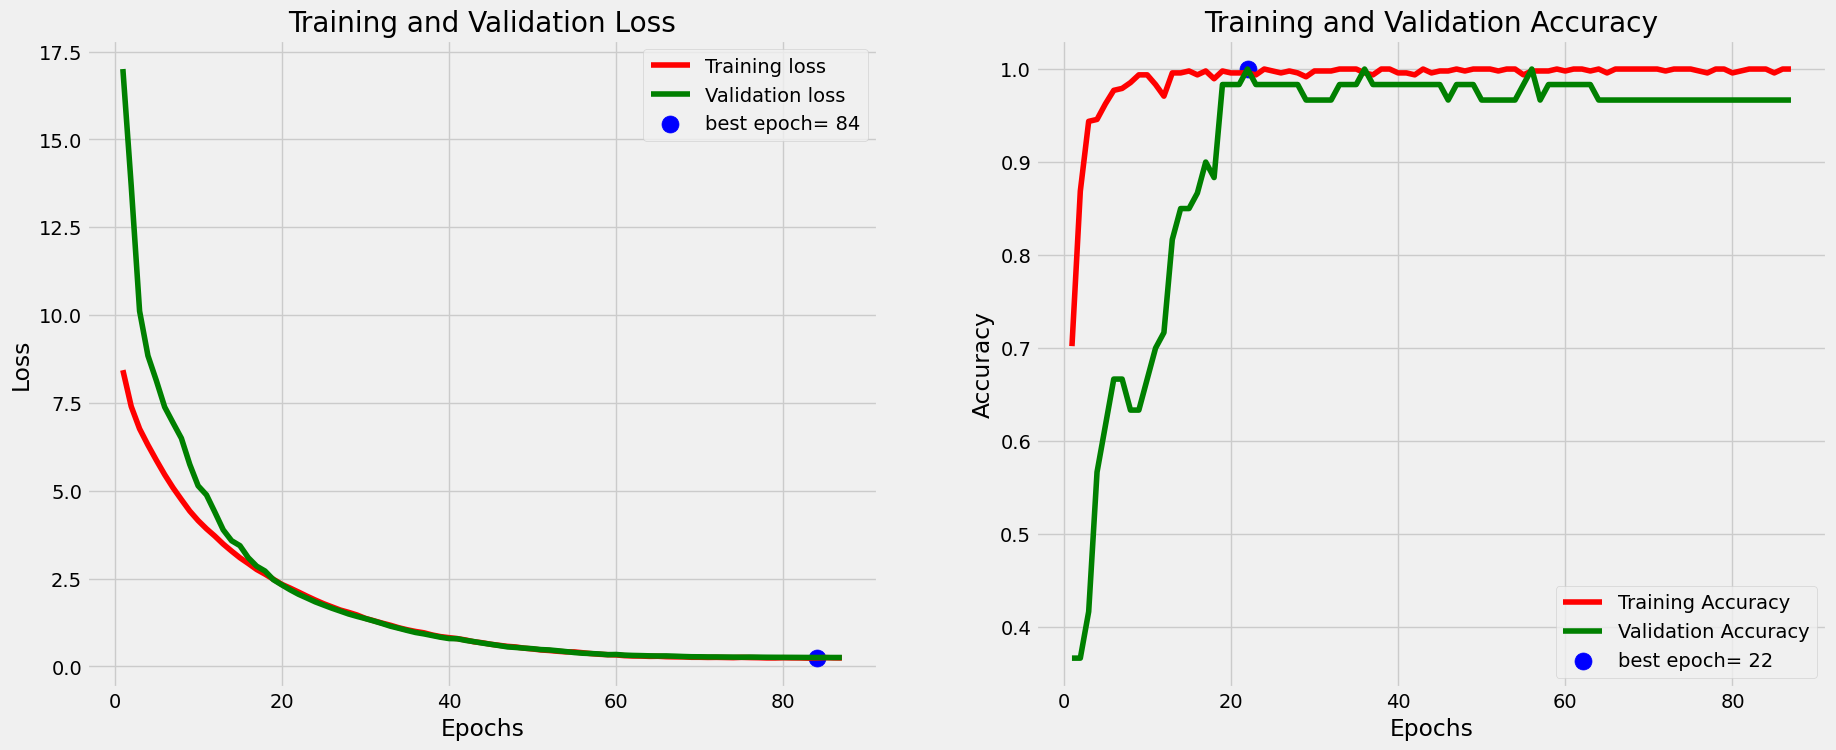

1/1 [==============================] - 1s 778ms/step - loss: 0.3493 - accuracy: 0.9333


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
tr_plot(history,0)
subject='mangos'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
model.save('eff_model.h5')


# **Resnet**

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

resnet_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

r_model = models.Sequential([
    resnet_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

for layer in r_model.layers:
    layer.trainable = False

r_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history2 = r_model.fit(
        train_generator,
        epochs=100,
        validation_data=validation_generator,
        verbose=1)

Epoch 1/100
15/15 [==============================] - 15s 838ms/step - loss: 3.4690 - accuracy: 0.3146 - val_loss: 1.8147 - val_accuracy: 0.3000
Epoch 2/100
15/15 [==============================] - 11s 717ms/step - loss: 3.3615 - accuracy: 0.3000 - val_loss: 1.9444 - val_accuracy: 0.3000
Epoch 3/100
15/15 [==============================] - 11s 732ms/step - loss: 3.4379 - accuracy: 0.3104 - val_loss: 1.9430 - val_accuracy: 0.2667
Epoch 4/100
15/15 [==============================] - 11s 742ms/step - loss: 3.3232 - accuracy: 0.3208 - val_loss: 1.8133 - val_accuracy: 0.3417
Epoch 5/100
15/15 [==============================] - 11s 682ms/step - loss: 3.4053 - accuracy: 0.3021 - val_loss: 1.9651 - val_accuracy: 0.2917
Epoch 6/100
15/15 [==============================] - 14s 908ms/step - loss: 3.3281 - accuracy: 0.2812 - val_loss: 1.7873 - val_accuracy: 0.2833
Epoch 7/100
15/15 [==============================] - 10s 701ms/step - loss: 3.4295 - accuracy: 0.3146 - val_loss: 1.8312 - val_accuracy:

In [50]:
loss, accuracy = model.evaluate(test_gen)
print('Testing Accuracy: {:.2f}%'.format(accuracy*100))

1/1 [==============================] - 1s 541ms/step - loss: 0.3210 - accuracy: 0.9667
Testing Accuracy: 96.67%


In [ ]:
test_loss, test_accuracy = r_model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_accuracy}')

In [25]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

# **Efficient NET again**

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers, layers, Model
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.optimizers import Adamax


sdir = '/content/drive/MyDrive/Grading_dataset'
classlist = os.listdir(sdir)
filepaths = []
labels = []
for c in classlist:
    classpath = os.path.join(sdir, c)
    for f in os.listdir(classpath):
        filepaths.append(os.path.join(classpath, f))
        labels.append(c)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data_dir = pathlib.Path('/content/drive/MyDrive/Grading_dataset')

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 480 images belonging to 4 classes.
Found 120 images belonging to 4 classes.
Found 600 images belonging to 4 classes.


In [ ]:
classes = list(train_generator.class_indices.keys())
class_count = len(classes)
train_steps = np.ceil(len(train_generator.labels) / batch_size)

base_model = EfficientNetB2(include_top=False, weights="imagenet", input_shape=(height, width, channels), pooling='max')
x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(base_model.output)
x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
                 bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = layers.Dropout(rate=0.45, seed=123)(x)
output = layers.Dense(class_count, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 100
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
]
history = model.fit(train_generator, epochs=epochs, verbose=1, callbacks=callbacks, validation_data=validation_generator,
                    validation_steps=None, shuffle=False, initial_epoch=0)

Epoch 1/100
15/15 [==============================] - 13s 866ms/step - loss: 7.7314 - accuracy: 0.7875 - val_loss: 10.7007 - val_accuracy: 0.3333 - lr: 1.2500e-04
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 7.6690 - accuracy: 0.8167
Epoch 2: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
15/15 [==============================] - 12s 826ms/step - loss: 7.6690 - accuracy: 0.8167 - val_loss: 11.3326 - val_accuracy: 0.3333 - lr: 1.2500e-04
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 7.5599 - accuracy: 0.8375
Epoch 3: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
15/15 [==============================] - 13s 881ms/step - loss: 7.5599 - accuracy: 0.8375 - val_loss: 12.1553 - val_accuracy: 0.3333 - lr: 6.2500e-05
Epoch 4/100
15/15 [==============================] - ETA: 0s - loss: 7.5334 - accuracy: 0.8375
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Restoring model weights f

In [ ]:
acc=model.evaluate(test_generator, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
model.save('eff_model.h5')

InvalidArgumentError: Graph execution error:

Detected at node categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-41-e89ba18d4131>", line 6, in <cell line: 6>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1856, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2296, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 4108, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1919, in test_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5579, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[60,4] labels_size=[60,3]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_test_function_182737]

In [ ]:
eff.summary()

In [ ]:
vgg.summary()

# **Test**

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/eff_model.h5')
model.summary()

OSError: No file or directory found at /content/drive/MyDrive/eff_model.h5

In [45]:
loss, accuracy = model.evaluate(test_gen)
print('Test Accuracy: {:.2f}%'.format(accuracy*100))

1/1 [==============================] - 1s 576ms/step - loss: 0.3210 - accuracy: 0.9667
Test Accuracy: 96.67%
